# Combined plot for experiments 3R and 6
This is for the AAMAS paper.

In [1]:
import pickle
import os
from glob import glob
from matplotlib.backend_bases import register_backend
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from model import analyse
import numpy as np
from scipy import stats

# switch to pgf backend -- it is better at producing small pdf files
from matplotlib.backends.backend_pgf import FigureCanvasPgf

register_backend("pdf", FigureCanvasPgf)

# add the correct path to latex into PATH. This depends on the system!
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

# pretty inline display
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# use a more modern style for plots
plt.style.use(style="ggplot")

plt.rcParams.update(
    {
        # Use 9pt font in plots, to match 9pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "font.family": "serif",
        # TeX setup for inline backend
        "text.usetex": True,
        "text.latex.preamble": r"""
            \usepackage{libertine}
            \usepackage[libertine]{newtxmath}""",
        # TeX setup for pdf backend
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
        "pgf.texsystem": "pdflatex",
        "pgf.preamble": r"""
            \usepackage{libertine}
            \usepackage[libertine]{newtxmath}""",
    }
)

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 7.0056
SINGLE_COLUMN_FIG_WIDTH = 3.337

## Load Data

In [2]:
## Load experiment 3R data

output_dir = "./experiments/experiment3R/experiment3R_output"
file_pattern = "experiment3R_results_*.pickle"

results_exp3R = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results_exp3R.append(run_results)

print(f"Loaded {len(results_exp3R)} files")

Loaded 1536 files


In [3]:
## Load experiment 6 data

output_dir = "./experiments/experiment6/experiment6_output"
file_pattern = "experiment6_results_*.pickle"

results_exp6 = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results_exp6.append(run_results)

print(f"Loaded {len(results_exp6)} files")

Loaded 128 files


## Process experiment 3R data

In [4]:
rows = []

for run_result in results_exp3R:
    run_id = run_result["run_id"]
    run_length = run_result["run_length"]
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["reasoning_level"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coefficient"]
    action_dist_0 = run_result["action_dist_0"]
    discount_factor = run_result["discount_factor"]

    run_actions = run_result["actions"]
    prop_no_action = (
        (run_actions["action"] == 0)
        | ((run_actions["action"] == "a") & (run_actions["attack_successful"].isnull()))
    ).mean()
    prop_attack = (
        (run_actions["action"] == "a") & (~run_actions["attack_successful"].isnull())
    ).mean()
    prop_hide = (run_actions["action"] == 1).mean()
    rows.append(
        (
            run_id,
            run_length,
            attack_reward,
            reasoning_level,
            exploration_coef,
            softargmax_coef,
            action_dist_0,
            discount_factor,
            prop_no_action,
            prop_attack,
            prop_hide,
        )
    )

prop_action_data = pd.DataFrame(
    rows,
    columns=(
        "run_id",
        "run_length",
        "attack_reward",
        "reasoning_level",
        "exploration_coef",
        "softargmax_coef",
        "action_dist_0",
        "discount_factor",
        "prop_no_action",
        "prop_attack",
        "prop_hide",
    ),
)

# add bins for attack reward
bins = np.linspace(-0.2, 0.1, 31)
prop_action_data["attack_reward_bin"] = pd.cut(
    x=prop_action_data["attack_reward"], bins=bins, include_lowest=True
)

In [5]:
prop_action_data.groupby("attack_reward_bin").size()

attack_reward_bin
(-0.201, -0.19]      48
(-0.19, -0.18]       48
(-0.18, -0.17]       48
(-0.17, -0.16]       56
(-0.16, -0.15]       48
(-0.15, -0.14]       64
(-0.14, -0.13]       48
(-0.13, -0.12]       48
(-0.12, -0.11]       72
(-0.11, -0.1]        24
(-0.1, -0.09]        56
(-0.09, -0.08]       64
(-0.08, -0.07]       48
(-0.07, -0.06]       40
(-0.06, -0.05]       56
(-0.05, -0.04]       48
(-0.04, -0.03]       56
(-0.03, -0.02]       48
(-0.02, -0.01]       40
(-0.01, 2.78e-17]    48
(2.78e-17, 0.01]     72
(0.01, 0.02]         48
(0.02, 0.03]         48
(0.03, 0.04]         48
(0.04, 0.05]         48
(0.05, 0.06]         48
(0.06, 0.07]         56
(0.07, 0.08]         48
(0.08, 0.09]         64
(0.09, 0.1]          48
dtype: int64

## Process experiment 6 data

In [6]:
attack_streak_rows = []
peace_streak_rows = []

raw_attack_streak_data = []
raw_peace_streak_data = []

for run_result in results_exp6:
    run_id = run_result["run_id"]
    run_length = run_result["run_length"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coef"]
    reasoning_level = run_result["reasoning_level"]
    action_dist_0 = run_result["action_dist_0"]

    # exclude runs that were less than 80 time steps (an arbitrary number)
    if run_length < 80:
        continue

    if action_dist_0 != "random":
        continue

    if exploration_coef != 0.6:
        continue

    if softargmax_coef != 0.1:
        continue

    print(run_length, reasoning_level)

    run_action_data = run_result["actions"]

    # analyse streaks
    run_attack_streaks = analyse.count_attack_streaks(run_action_data)
    run_peace_streaks = analyse.count_peace_streaks(run_action_data)

    # add individual streaks to raw data
    raw_attack_streak_data.extend(
        (
            streak_length
            for streak_length in run_attack_streaks
            for _ in range(run_attack_streaks[streak_length])
        )
    )
    raw_peace_streak_data.extend(
        (
            streak_length
            for streak_length in run_peace_streaks
            for _ in range(run_peace_streaks[streak_length])
        )
    )

201 1
201 1
201 0
201 1
201 0
201 0
201 0
201 1
201 1
201 0
201 0
201 1
201 1
201 1
201 0
201 0


## Plot the combined figure

  params: FitParams(p=0.7654045986977311, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(p=0.25521536477124873, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'


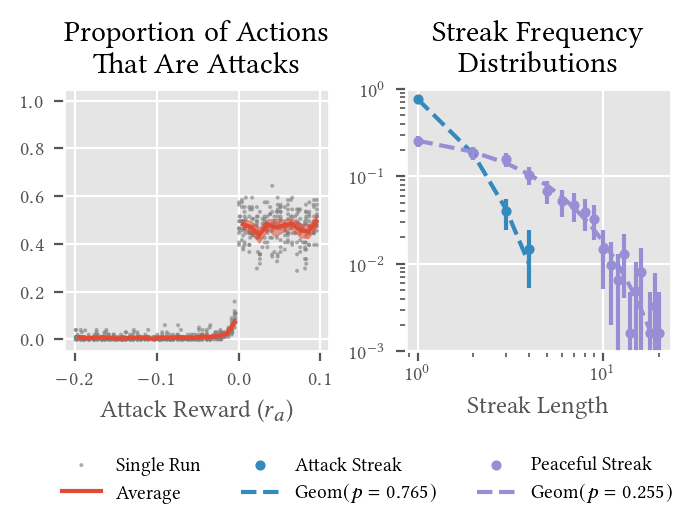

In [7]:
# which columns from the action proportion data to plot
metrics = ("prop_attack",)

# nicer looking titles
fancy_titles = {
    "prop_no_action": "No action",
    "prop_attack": "Attack",
    "prop_hide": "Hide",
}

# colours for the different reasoning levels
colors = {0: "gray", 1: "gray"}

# only choose data points where the properties are as desired
prop_action_data_ = prop_action_data[
    (prop_action_data["run_length"] >= 50)
    & (prop_action_data["action_dist_0"] == "random")
]

# define figure
fig, axs = plt.subplots(
    ncols=2,
    nrows=1,
    constrained_layout=True,
    figsize=(SINGLE_COLUMN_FIG_WIDTH, 2.5),
    sharey=False,
    sharex=False,
)

### First, plot the proportion of actions metrics (experiment 3R)

# which column of the figure to plot into
plot_column = 0

for i, metric in enumerate(metrics):
    # plot all the individual data points
    axs[plot_column].scatter(
        x=prop_action_data_["attack_reward"],
        y=prop_action_data_[metric],
        marker="o",
        s=1,
        c=[colors[l] for l in prop_action_data_["reasoning_level"]],
        alpha=0.5,
        label="Single Run",
    )

    # calculate average proportions for each attack reward bin
    prop_action_data_groups = prop_action_data_.groupby("attack_reward_bin")
    avg_metric = prop_action_data_groups.mean(numeric_only=True)[metric]
    avg_metric_error_margin = prop_action_data_groups[metric].aggregate(
        lambda x: analyse.t_confidence_interval(x)[1]
    )
    midpoints = pd.IntervalIndex(avg_metric.index).mid

    if metric == "prop_attack":
        ## show discontinuity at 0 for the attack proportion
        # plot towards the left from the discontinuity
        subset = midpoints < 0
        lines = axs[plot_column].plot(
            midpoints[subset], avg_metric[subset], label="Average"
        )
        color = lines[0].get_color()
        axs[plot_column].fill_between(
            midpoints[subset],
            avg_metric[subset] - avg_metric_error_margin[subset],
            avg_metric[subset] + avg_metric_error_margin[subset],
            color=color,
            alpha=0.5,
        )

        # plot towards the right from the discontinuity
        subset = midpoints > 0
        axs[plot_column].plot(midpoints[subset], avg_metric[subset], color=color)
        axs[plot_column].fill_between(
            midpoints[subset],
            avg_metric[subset] - avg_metric_error_margin[subset],
            avg_metric[subset] + avg_metric_error_margin[subset],
            color=color,
            alpha=0.5,
        )
    else:
        ## for other variables there is no discontinuity
        axs[plot_column].plot(midpoints, avg_metric)
        axs[plot_column].fill_between(
            midpoints,
            avg_metric - avg_metric_error_margin,
            avg_metric + avg_metric_error_margin,
            alpha=0.5,
        )

    axs[plot_column].set_xlabel(
        r"Attack Reward ($r_a$)", color=plt.rcParams["xtick.color"]
    )
    # axs[plot_column].set_ylabel("Proportion of Actions", color=plt.rcParams['xtick.color'])
    axs[plot_column].set_title(
        "Proportion of Actions\nThat Are Attacks", fontsize="large"
    )
    axs[plot_column].set_ylim((-0.05, 1.05))

### Then, plot the streak distributions (experiment 6)

# titles for attack streak data (0) and peace streak data (1)
data_titles = {0: "Attack Streak", 1: "Peaceful Streak"}

# which column of our figure to plot into
plot_column = 1

for i, data in enumerate((raw_attack_streak_data, raw_peace_streak_data)):
    # calculate total number of streaks
    n_streaks = len(data)

    # choose colour according to the standard color cycle
    color = f"C{i+1}"

    # count frequencies
    counts = pd.Series(data).value_counts(normalize=True)

    # calculate uncertainty: a simple confidence interval for the proportion of
    # time we randomly choose a random value from the population
    error_margins = 1.96 * np.sqrt(counts * (1 - counts) / n_streaks)

    # plot the streaks
    axs[plot_column].scatter(
        x=counts.index, y=counts, color=color, marker="o", label=data_titles[i], s=10
    )
    axs[plot_column].errorbar(
        x=counts.index, y=counts, yerr=error_margins, color=color, fmt="none"
    )

    # fit a geometric distribution to the streak data
    fit = stats.fit(stats.geom, data=data, bounds={"p": (0, 1)})
    print(fit)

    # visualise the probability mass function of the fitted geometric distribution
    k = np.arange(1, max(data) + 1)
    y = stats.geom.pmf(k=k, p=fit.params.p)
    axs[plot_column].plot(
        k, y, color=color, linestyle="dashed", label=rf"Geom$(p={fit.params.p:.3f})$"
    )

    # adjust
    axs[plot_column].set_yscale("log")
    axs[plot_column].set_xscale("log")
    # axs[plot_column].legend(loc="outside lower right")
    axs[plot_column].set_xlabel("Streak Length", color=plt.rcParams["xtick.color"])
    axs[plot_column].set_ylim((1e-3, 1))
    axs[plot_column].set_title("Streak Frequency\nDistributions", fontsize="large")

axs[1].tick_params(axis="x", which="major", pad=1.5)

# add a figure legend for the distributions
fig.legend(loc="outside lower right", frameon=False, ncol=3)

# plt.savefig("paper/experiment3R_6_combined.pdf")
plt.show()